# Amazon Product Review Sentiment Analysis

# Table of Contents

- [ 1 - Business Problem](#1)
- [ 2 - Imports](#2)
  - [ 2.1 - Helper Functions](#2.1)
  - [ 2.2 - Load Data](#2.2)
- [ 3 - Data Description](#3.0)
  - [ 3.1 - Sample Data](#3.1)
  - [ 3.2 - Rename Columns](#3.2)
  - [ 3.3 - Check NaN](#3.3)
  - [ 3.4 - Data Types](#3.4)
- [ 4 - Data Understanding](#4.0)
  - [ 4.1 - Class Balance](#4.1)
  - [ 4.2 - Inspect Reviews](#4.2)
  - [ 4.3 - Most Used Words](#4.3)
- [ 5 - Text Processing](#5.0)
  - [ 5.1 - Positive Words](#5.1)
  - [ 5.2 - Negative Words](#5.2)
- [ 6 - Prepare Data](#6.0)
  - [ 6.1 - Tokenization](#6.1)
  - [ 6.2 - Word Embedding](#6.2)
- [ 7 - Model Architecture and Training](#7.0)
  - [ 7.1 - Model Training](#7.1)
  - [ 7.2 - Analyze Sentiments](#7.2)
  - [ 7.3 - Evaluate on Validation](#7.3)
  - [ 7.4 - Predict on Test](#7.4)
- [ 8 - Manual Text Prediction](#8.0)
- [ 9 - Business Performance](#9.0)

<a name='1'></a>
# Business Problem

## Background:
Amazon, the world's largest online retailer, prides itself on customer-centricity. Customer reviews form the backbone of Amazon's product ecosystem, guiding millions of purchasing decisions daily and playing a pivotal role in vendor and product rankings. As the platform continues to scale, the sheer volume of reviews makes manual monitoring an insurmountable task. 

## Problem Statement:
While Amazon's current review system with star ratings gives a quantitative insight into product quality, it lacks the granularity needed to understand the nuanced opinions of its vast user base. Moreover, with millions of reviews generated daily, manual analysis becomes an insurmountable challenge.

## The Limitations of Star Ratings:

- Lack of Specificity: A customer might give a product 3 stars, but what does that mean? Are they somewhat satisfied, or did they encounter specific issues? Without the accompanying text, it's hard to say.  
- Varied Interpretations: One person's 5-star experience might be another person's 4-star experience. Relying solely on star ratings can be misleadig.
- No Actionable Insights: Star ratings don't tell you what the problems are. If a product receives a 1-star rating, what should the seller improve? The packaging? The product quality? The shipping time? Without a textual review, it's all guesswork

### Examples of Star Ratings:

- Here we have 2 opposite reviews of the same product both with 3 stars
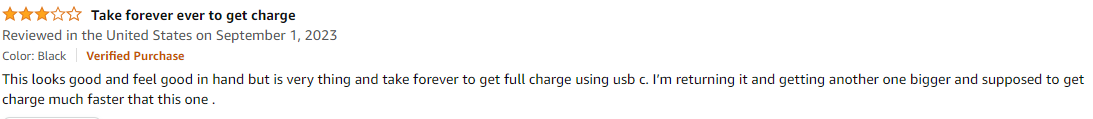
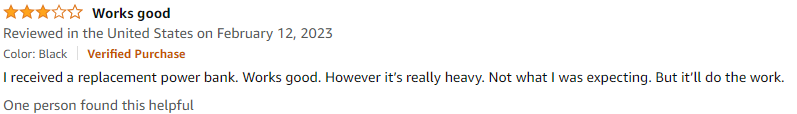

- Example of 4 stars review with Negative Sentiment
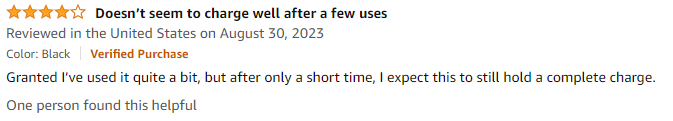

- We can even find 5 stars with Negative Sentiment:
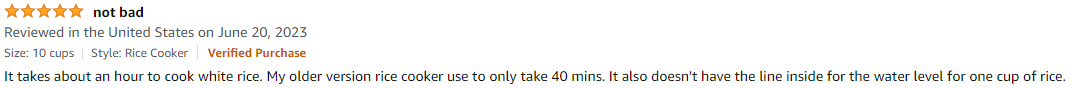.

## Objective:
Develop an automated solution using machine learning and natural language processing techniques to:
1. Accurately identify negative reviews among the millions of reviews posted on Amazon daily.
2. Categorize the severity of the negative feedback to prioritize actions.
3. Extract actionable insights from negative reviews to provide to vendors, helping them improve product quality and customer experience.
   
## Value Proposition:
By effectively identifying and addressing negative reviews, Amazon aims to:
1. Enhance customer trust by showing responsiveness to feedback.
2. Increase customer retention by resolving issues proactively.
3. Boost overall platform sales by improving product and vendor quality through actionable feedback.
4. Potentially save millions in revenue by preventing customer churn and fostering brand loyalty.

## Measure of Success:
A successful solution will showcase a significant improvement in the **Recall metric**, ensuring that the vast majority of negative reviews are captured. The financial implications of improved customer retention and vendor product enhancement will serve as a testament to the initiative's success.


<a name='2'></a>
# 2.0 Imports

In [67]:
import pandas                            as pd
import string
import re
import numpy                             as np
import warnings

import seaborn                           as sns
import matplotlib.pyplot                 as plt
import numpy                             as np

import nltk
from nltk.stem                          import WordNetLemmatizer
from nltk.corpus                        import stopwords, wordnet

from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

from wordcloud                          import WordCloud

from keras.preprocessing.text           import Tokenizer
from keras.preprocessing.sequence       import pad_sequences
import tensorflow                       as tf

sns.set_style('darkgrid')

warnings.filterwarnings('ignore')

<a name='2.1'></a>
## 2.1 Helper Funtions

In [90]:
# Lemmatize Words
def lemmatize_word(word):
    lemma = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    return lemmatizer.lemmatize(lemma, pos=wordnet.NOUN)

# Process Function
def process_text(text):
    #convert do uncased
    text = text.lower()
    
    # Remove Pontuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokemnization, lemmatization and stopwords removal
    words = text.split()
    filtered_and_lemmatized_words = [lemmatize_word(word) for word in words if word.lower() not in english_stopwords]
    text = ' '.join(filtered_and_lemmatized_words)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 350,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=0)
    recall = recall_score(y_true, y_pred, pos_label=0)
    f1 = f1_score(y_true, y_pred, pos_label=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def sample_prediction(model, tokenizer, validation_data, original_data, num_samples=5, threshold=0.5):
    # Select random sample
    sample_indices = np.random.choice(validation_data.index, size=num_samples, replace=False)
    
    # Obtain process and original text separated
    sample_texts_processed = validation_data.loc[sample_indices, 'text'].tolist()
    sample_texts_original = original_data.loc[sample_indices, 'text'].tolist()
    
    sample_true_sentiments = validation_data.loc[sample_indices, 'sentiment'].tolist()
    
    # Tokenize
    sequences = tokenizer.texts_to_sequences(sample_texts_processed)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Predict
    predictions = model.predict(data)
    predicted_sentiments = [1 if pred[0] > threshold else 0 for pred in predictions]
    
    # Show results
    for text, true_sent, pred_sent in zip(sample_texts_original, sample_true_sentiments, predicted_sentiments):
        print('-' * 100)
        print(f"Original Text: {text}")
        print(f"Original Sentiment: {true_sent}")
        print(f"Predicted Sentiment: {pred_sent}")
    print('-' * 100)

def predict_manual_text(text):
    text = process_text(text)
    
    # Convert process text to list
    sequence_text = tokenizer.texts_to_sequences([text])
    
    # Max len for sequence
    X_text = pad_sequences(sequence_text, maxlen=MAX_SEQUENCE_LENGTH)

    y_pred = model.predict(X_text)[0][0]  # Positive class probability

    # Interval logic the determine sentiment
    if y_pred > 0.6:
        sentiment = "Positive"
    elif y_pred < 0.4:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    
    return sentiment

<a name='2.2'></a>
## 2.2 Load Data

In [3]:
PATH = '/home/edilson07/projects/'

df_raw = pd.read_csv(PATH + 'train.csv', header=None)
df_raw.columns = ['sentiment','title','text']

In [4]:
df_raw.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
df_raw.shape

(3600000, 3)

<a name='3.0'></a>
# 3.0 Data Description

The full dataset contains 3.6 million reviews. However, due to computational constraints, I will be working with a subset of 90,000 examples, which represents 2.5% of the entire dataset.

<a name='3.1'></a>
## 3.1 Sample Data

In [6]:
df_raw, _ = train_test_split(df_raw, test_size=0.975, stratify=df_raw['sentiment'], random_state=42)
df_raw = df_raw.reset_index(drop=True)
df_raw.shape

(90000, 3)

<a name='3.2'></a>
## 3.2 Rename Columns

In [7]:
df_desc = df_raw.copy()

I won't need the title column

In [8]:
df_desc = df_desc.drop(['title'], axis=1)

Transform sentiment to Categorical

In [9]:
df_desc['sentiment'] = df_desc['sentiment'].apply(lambda x: 'Negative' if x == 1 else 'Positive')

<a name='3.3'></a>
## 3.3 Check NaNs

In [10]:
df_desc.isna().sum()

sentiment    0
text         0
dtype: int64

<a name='3.4'></a>
## 3.4 Data Types

In [11]:
df_desc.dtypes

sentiment    object
text         object
dtype: object

<a name='4.0'></a>
# 4.0 Data Understanding

<a name='4.1'></a>
## 4.1 Check Class Balance

In [12]:
df_eda = df_desc.copy()

In [13]:
df_eda['sentiment'].value_counts(normalize=True)

sentiment
Positive    0.5
Negative    0.5
Name: proportion, dtype: float64

The target is balanced.

<a name='4.2'></a>
## 4.2 Inspect Reviews

Let's take a if we have extreme large reviews

In [14]:
#Size of the text
df_eda['text_lenght'] = df_eda['text'].apply(lambda x: len(str(x).split()))
df_eda['text_lenght'].sort_values(ascending=False)

88289    216
67922    210
74980    209
18615    208
88692    207
        ... 
82750      7
63595      6
9253       5
53474      3
42659      1
Name: text_lenght, Length: 90000, dtype: int64

In [15]:
df_eda.query('text_lenght == 216')['text'].iloc[0]

"I have been trying to use this Shaver for a month now, and it still will not shave my neck, and I have to go over my face slowly about 4 time before it starts it even feel like I might be getting a close shave. I have tried it in the shower wet and before or after the shower, it still don't work. Oh but it sounds like it does! In the shower with a little gel on my face, this thing sound like it cutting every hair I have, but when I rinse off my face, I see that it didn't shave as well as I would like and that I'm still going to have to go back over my neck with a razor. If I was a 60 year old man, this would be OK. But no, I'm 27 trying to make a like for my self, and if my boss saw I can't even shave right, what's he going to think?The battery life is good, last about a week with one 5 minutes each day. The cleaner / charger is really loud so the only time I can use it is when I'm not home. For a $140 shaver, I was expecting a lot more. Save your money and try something else."

That's a long review but I will consider to be extremely long until 512 words. So no need to filter anything here.

<a name='4.3'></a>
## 4.3 Most Used Words

We will look now which words appears the most on the dataset.

In [16]:
from collections import Counter

#concatenate all texts in one variable
all_texts = ''.join(df_eda['text'])

#Take words
words = all_texts.split()

#Count Words
word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=['word','count'])

In [17]:
df_words.sort_values(by='count', ascending=False).head(20)

,word,count
15,the,293319
22,and,178579
39,to,163666
36,a,160514
71,I,142202
33,of,132006
20,is,115505
149,it,92125
56,this,90573
3,in,74073


As we can see there are a lot of 'stopwords', words that don't carry any meaning, we need to remove them. The next section we will make some text processing for this kind of problems.

<a name='5.0'></a>
# 5.0 Text Preprocessing

### Stemming/ Lemmatization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes. 

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word.

![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)


### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...

![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

I will use **NLTK** Python library to make this text processing

In [18]:
# Download necessary resources for nltk
nltk.download('wordnet')
nltk.download('stopwords')

# Inicialize Lemmatizer and set Stopwords in english
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

df_eda['text'] = df_eda['text'].apply(process_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's see how our most used words ended with now

In [19]:
#concatenate all texts in one variable
all_texts_filtered = ''.join(df_eda['text'])

#Take words
words_filtered = all_texts_filtered.split()

#Count Words
word_counts_filtered = Counter(words_filtered)
df_words_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['word','count'])

In [20]:
top_20_words = df_words_filtered.sort_values(by='count', ascending=False).head(20)

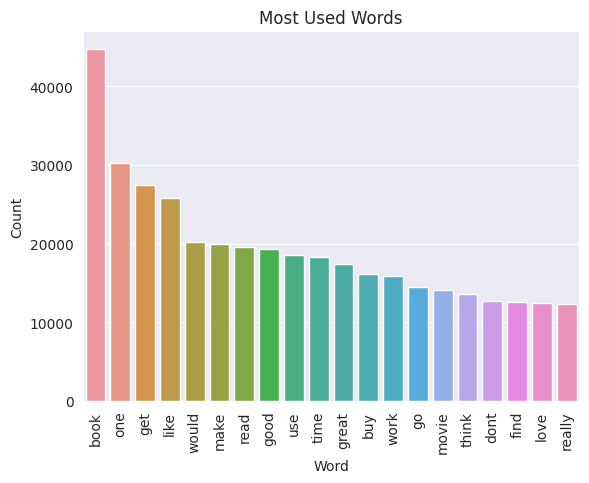

In [21]:
sns.barplot(top_20_words, x='word', y='count')
plt.xticks(rotation=90);
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Used Words');


Notice that 'book' is most used word, because the majority of sales in amazon are from books. But there are some words that capture the sentiment that are used a lot, like: 'good', 'great', 'love'.

<a name='5.1'></a>
### 5.1 Positive Words

Let's make some Word Cloud to see more visual the most used words. First, looking at POSITIVE reviews

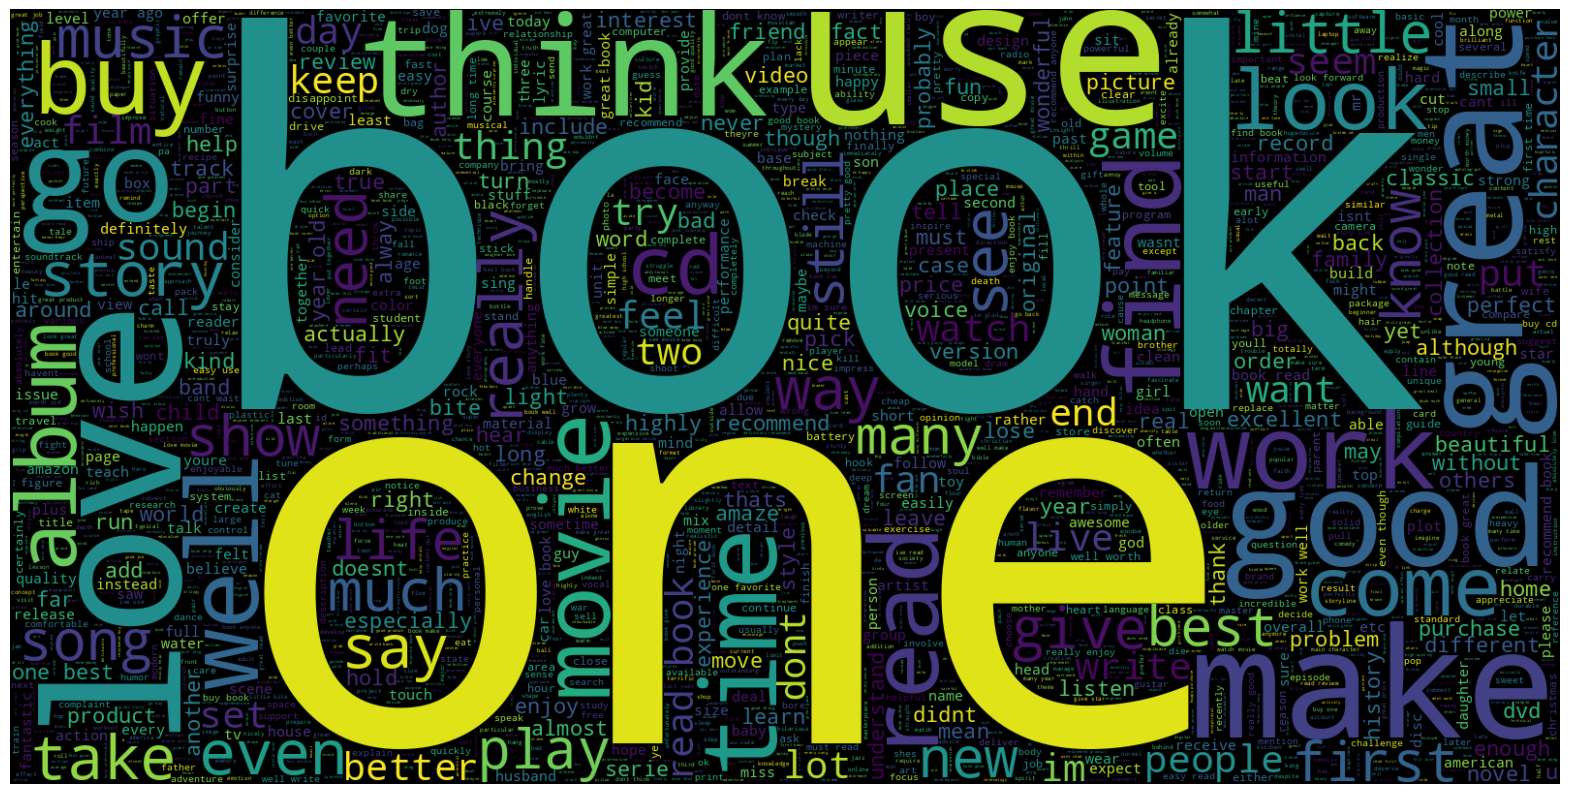

In [22]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_eda[df_eda.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")  # Desativar os eixos
plt.gca().set_frame_on(False)  # Remover a borda
plt.show()

<a name='5.2'></a>
### 5.2 Negative Words

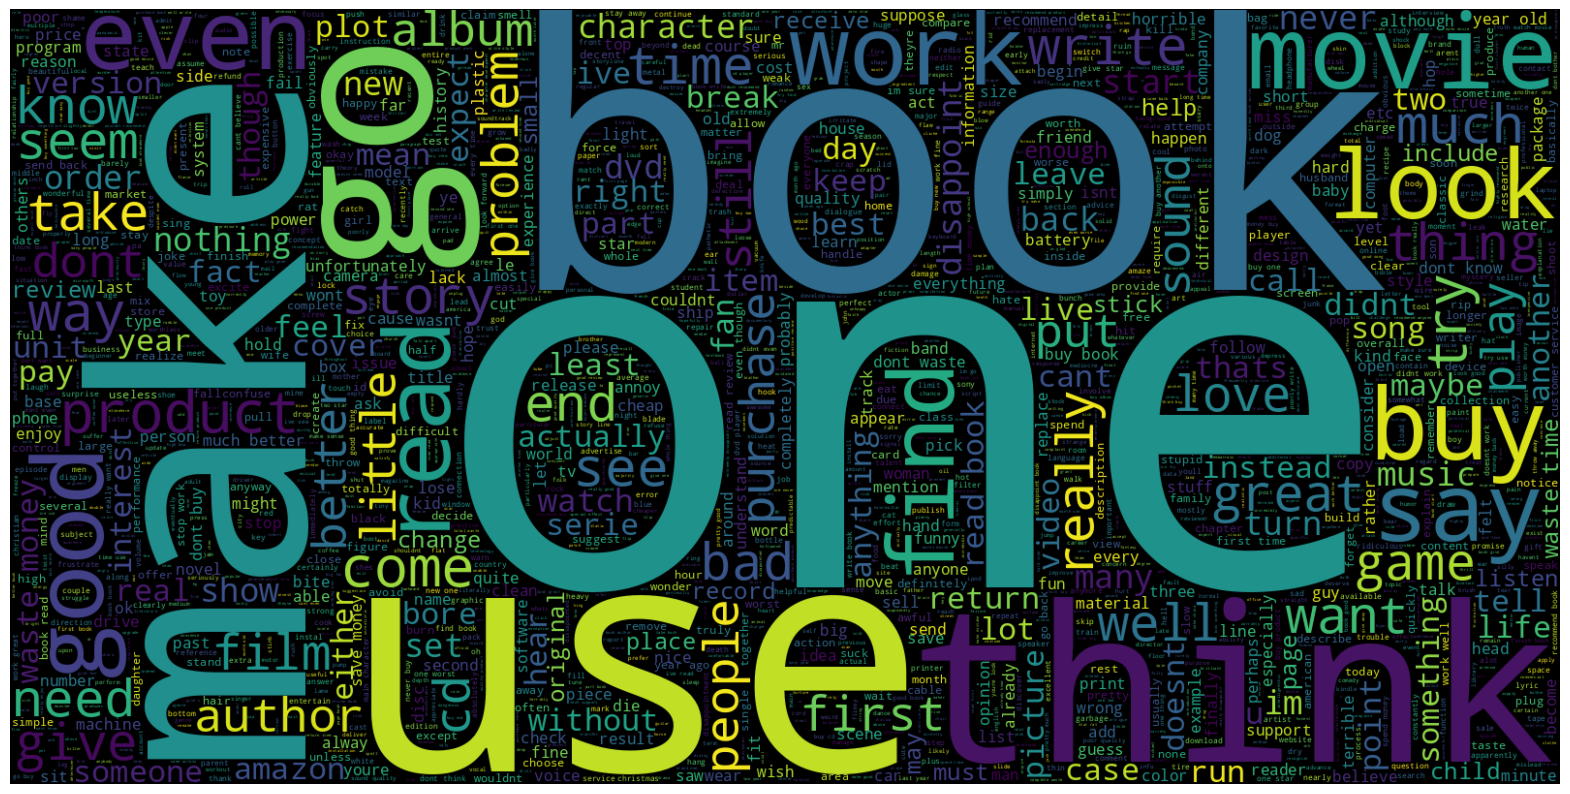

In [23]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_eda[df_eda.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")  # Desativar os eixos
plt.gca().set_frame_on(False)  # Remover a borda
plt.show()

We have some negative words that appears here, like 'disappoint', 'bad', 'never', 'waste time'. The algorithm will probably seek for these words in order to classify the sentiment.

<a name='6.0'></a>
# 6.0 Prepare Data

Now let's prepare our data to train our Machine Learning Model.

In [24]:
df_prep = df_eda.copy()
df_prep = df_prep.loc[:,['sentiment','text']]

In [25]:
sentiment_map = {
    'Positive':1,
    'Negative':0
}

df_prep['sentiment'] = df_prep['sentiment'].map(sentiment_map)

## Split Train-Validation

In [26]:
train, validation = train_test_split(df_prep, test_size=0.3, random_state=42, stratify=df_prep['sentiment'])

<a name='6.1'></a>
## 6.1 Tokenization

# Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization.**
![Tokenization](https://miro.medium.com/v2/resize:fit:720/format:webp/1*PZYP2nL6Zc_jpkaHLRxLQQ.png)

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`MAX_NUM_WORDS` represents the total number of word in the vocabulary of our model, that means it will search for the 10.000 most used words and 'remember' them as tokens. 

In [27]:
# Define Vocabulary
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 512

#Define Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

#Train Tokenizer
tokenizer.fit_on_texts(train['text'])

#Transform the tokens in sequence
sequences_train = tokenizer.texts_to_sequences(train['text'])
sequences_validation = tokenizer.texts_to_sequences(validation['text'])

#Each sequence need to be the same size, padding complete them with zeros.
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_validation = pad_sequences(sequences_validation, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
# import pickle

# pickle.dump(tokenizer, open('/home/edilson07/projects/sentiment_analysis/tokenizer.pickle', 'wb'))

In [29]:
y_train = train['sentiment'].copy()
y_validation = validation['sentiment'].copy()

In [30]:
word_index = tokenizer.word_index

<a name='6.2'></a>
## 6.2 Word Embedding

Word Embeddings are dense representations of the individual words in a text, taking into account the context and other surrounding words that that individual word occurs with.

The dimensions of this real-valued vector can be chosen and the semantic relationships between words are captured more effectively than a simple Bag-of-Words Model.

![Word Embedding](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*SYiW1MUZul1NvL1kc1RxwQ.png)

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use **Transfer Learning**. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding lik**e GloVe & Word2V**ec gives more insights for a word which can be used for classificatiok.In this notebook, I use **GloVe Embedding from Stanford AI** which can be found [here](https://nlp.stanford.edu/projects/glove/)here

In [111]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
# GLOVE_PATH = '/home/edilson07/projects/llm_gen/glove.6B.zip'
# import zipfile

# with zipfile.ZipFile(GLOVE_PATH, 'r') as zip_ref:
#     zip_ref.extractall('/home/edilson07/projects/llm_gen/')

In [34]:
GLOVE_EMB = '/home/edilson07/projects/sentiment_analysis/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../best_model.hdf5'

In [44]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [45]:
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:  # Se o índice é maior ou igual a MAX_NUM_WORDS, continue para a próxima iteração
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Resulting Embedding Layer

In [46]:
embedding_layer = tf.keras.layers.Embedding(MAX_NUM_WORDS,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

<a name='7.0'></a>
# 7.0 Model Architecture and Training - LSTM

# Sequential Model in Deep Learning

In Deep Learning, the `Sequential` model is a linear approach to stacking layers, thereby constructing a machine learning model. It allows you to build models layer by layer, where each layer has weights corresponding to the following layer.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

## Breakdown of the Provided Model Architecture

The provided architecture is a Keras functional model, which allows for more flexibility as compared to the `Sequential` model. Let's detail each part:

### Input Layer

- **Input Layer**: This is the entry layer that receives the data. The shape defines the sequence length, which in this case is `MAX_SEQUENCE_LENGTH`.

### Embedding Layer

- **Embedding Layer**: Here we are using the embedding layer create before.

### Spatial Dropout

- **SpatialDropout1D**: Similar to regular Dropout, `SpatialDropout1D` deactivates (zeroes out) entire dimensions of the embedding. This helps make the model less sensitive to specific noise in embedding dimensions.

### Convolution Layer

- **Conv1D**: A one-dimensional convolutional layer. It slides filters over the input sequence to detect local patterns (like bigrams or trigrams). Here, it's using 64 filters and a kernel size of 5.

### Bi-directional LSTM

- **Bidirectional LSTM**: This is an LSTM layer that processes the input in two ways: one from start to end and another from end to start. This helps capture long-range patterns and dependencies in the text.

### Dense Layers

- **Dense Layers**: Fully connected layers. The `Dense` layer is a standard neural layer. Here, we have two such layers with 512 neurons each. In between them, we have a `Dropout` layer to prevent overfitting.

### Output Layer

- **Output Layer**: The final layer that provides the output. In this case, we have 1 neuron, corresponding to one of the 2 classes. The 'sigmoid' activation ensures the output is binary.

Finally, the model is compiled using the 'adam' optimizer and the 'binary_crossentropy' loss function, which is suitable for binary classification problems.

In [113]:
from tensorflow.keras.layers import Input, SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

# Input
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_layer')

# Embedding
embedded_sequences = embedding_layer(input_layer)

#Spatial Dropout similar to regular Dropout but for embeddings(spaces)
spatial_dropout = SpatialDropout1D(0.2, name='spatial_dropout')(embedded_sequences)

# Convolution
conv1 = Conv1D(64, 5, activation='relu', name='conv1')(spatial_dropout)

# Bi-directional LSTM
bi_lstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2), name='bi_lstm')(conv1)

# Dense layers
dense1 = Dense(512, activation='relu', name='dense1')(bi_lstm)
dropout = Dropout(0.5, name='dropout')(dense1)
dense2 = Dense(512, activation='relu', name='dense2')(dropout)

# Output
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense2)

# Compile model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 300)          3000000   
                                                                 
 spatial_dropout (SpatialDr  (None, 512, 300)          0         
 opout1D)                                                        
                                                                 
 conv1 (Conv1D)              (None, 508, 64)           96064     
                                                                 
 bi_lstm (Bidirectional)     (None, 128)               66048     
                                                                 
 dense1 (Dense)              (None, 512)               66048     
                                                           

<a name='7.1'></a>
## 7.1 Training Model

In [118]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [119]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

2023-09-24 17:59:30.710184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 129024000 exceeds 10% of free system memory.


Epoch 1/50
1969/1969 [==============================] - 958s 483ms/step - loss: 0.4680 - accuracy: 0.7800 - val_loss: 0.3919 - val_accuracy: 0.8186
Epoch 2/50
1969/1969 [==============================] - 986s 501ms/step - loss: 0.3893 - accuracy: 0.8268 - val_loss: 0.3613 - val_accuracy: 0.8386
Epoch 3/50
1969/1969 [==============================] - 963s 489ms/step - loss: 0.3564 - accuracy: 0.8430 - val_loss: 0.3596 - val_accuracy: 0.8370
Epoch 4/50
1969/1969 [==============================] - 986s 501ms/step - loss: 0.3301 - accuracy: 0.8575 - val_loss: 0.3480 - val_accuracy: 0.8454
Epoch 5/50
1969/1969 [==============================] - 963s 489ms/step - loss: 0.3082 - accuracy: 0.8674 - val_loss: 0.3773 - val_accuracy: 0.8458
Epoch 6/50
1969/1969 [==============================] - 917s 466ms/step - loss: 0.2861 - accuracy: 0.8784 - val_loss: 0.3744 - val_accuracy: 0.8435
Epoch 7/50
1969/1969 [==============================] - 957s 486ms/step - loss: 0.2734 - accuracy: 0.8846 - val_

In [120]:
#model.save('lstm_binary_model.h5')

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
from keras.models import load_model
model = load_model('/home/edilson07/projects/sentiment_analysis/src/lstm_binary_model.h5')

<a name='7.2'></a>
## 7.2 Analyze sentiments

Let's see how our model classify some of the texts:

In [32]:
sentiment_dict = {
    'Negative': 0,
    'Positive': 1
}

sentiment_map_reverse = {v: k for k, v in sentiment_dict.items()}


In [33]:
sample_prediction(model, tokenizer, validation, df_desc)

1/1 [==============================] - 0s 450ms/step
----------------------------------------------------------------------------------------------------
Original Text: Charles Wells put together a excellent reference book for those who want to explore the mountains of Southwest Colorado. Great pictures and descriptions of the best views of Colorado. Just perfect.
Original Sentiment: 1
Predicted Sentiment: 1
----------------------------------------------------------------------------------------------------
Original Text: This is a great cd to dance to by your self or in a party. It's really hard to keep still through Rockerfella Shank, Gangster Tripping, You're not From Brighton, Building it Up,Tearing It Down, Love Island, and Acid 8000. As Fatboy Slim put it best in a sample on Acid 8000, "If this don't make your booty move your booty most be dead!"
Original Sentiment: 1
Predicted Sentiment: 1
------------------------------------------------------------------------------------------

Great! Our model appears to generalize effectively. I'm particularly struck by the second example. Despite the phrase 'excellent book' in the sentence, the review was distinctly negative. Yet, the model astutely recognized this!

<a name='7.3'></a>
## 7.3 Evalute Metrics on Validation

In [34]:
y_pred = model.predict(X_validation)
y_pred_classes = (y_pred > 0.5).astype(int)


844/844 [==============================] - 86s 102ms/step


In [91]:
evaluate_metrics(y_validation, y_pred_classes)

Accuracy: 0.8454
Precision: 0.8442
Recall: 0.8472
F1 Score: 0.8457


We got a nice score on recall metric. Mearning that we could capture 84% of the negatives reviews even though we gonna classify some of them as positives.

### Confusion Matrix

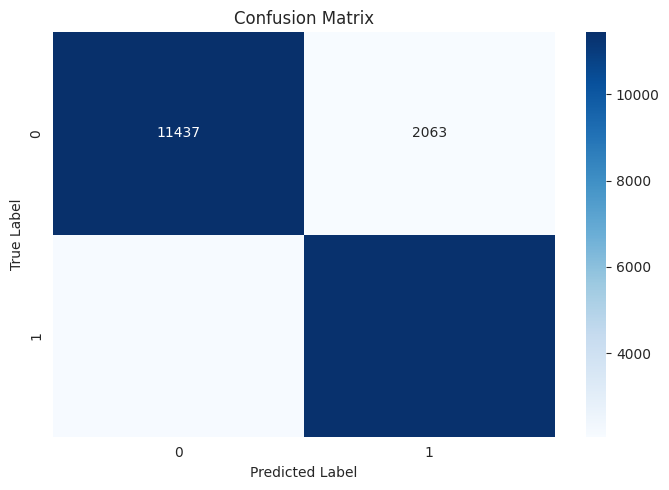

In [92]:
cmatrix = confusion_matrix(y_validation, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(7,5))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

In [93]:
print(cmatrix)

[[11437  2063]
 [ 2110 11390]]


For some reason my seaborn is not plotting correctly, but you can see the number using print(function)

## Plot Wrong Awswers Probability

In [38]:
df_y = pd.DataFrame(y_validation)
df_pred_classes = pd.DataFrame(y_pred_classes, columns=['y_pred'], index=df_y.index)
df_pred_probs = pd.DataFrame(y_pred, columns=['probabilities'], index=df_y.index)

error_indices = df_y[df_y['sentiment'] != df_pred_classes['y_pred']].index

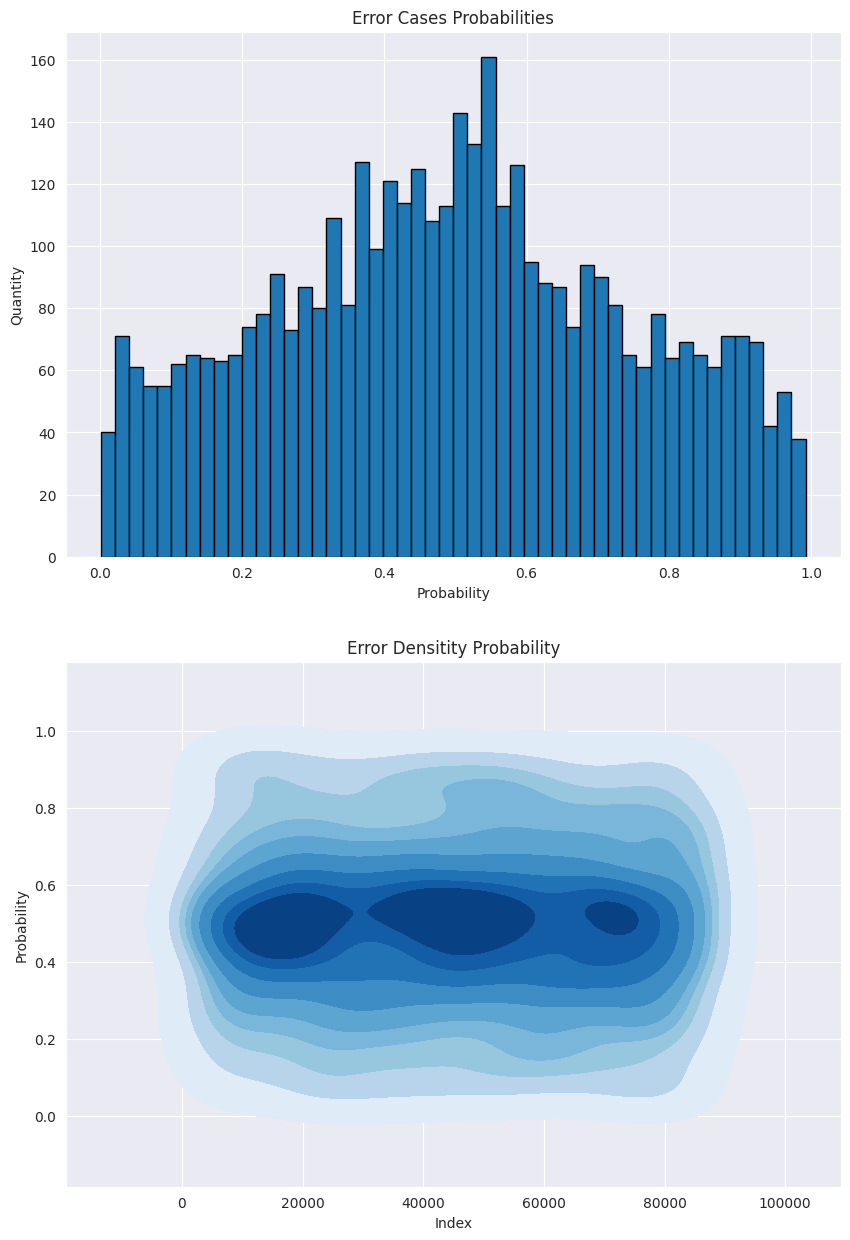

In [39]:
error_probs = df_pred_probs.loc[error_indices]

plt.figure(figsize=(10,15))

plt.subplot(2,1,1)
plt.hist(error_probs['probabilities'], bins=50, edgecolor='k')
plt.title('Error Cases Probabilities')
plt.xlabel('Probability')
plt.ylabel('Quantity')
plt.grid(True)

plt.subplot(2,1,2)
sns.kdeplot(x=error_indices, y=error_probs['probabilities'], cmap='Blues', fill=True)
plt.title('Error Densitity Probability')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.grid(True)

We can see that most error happen when probability is around 40% and 60% percent. It might be a good ideia to set this limits as 'Neutral' Sentiment.

## PR Curve and ROC

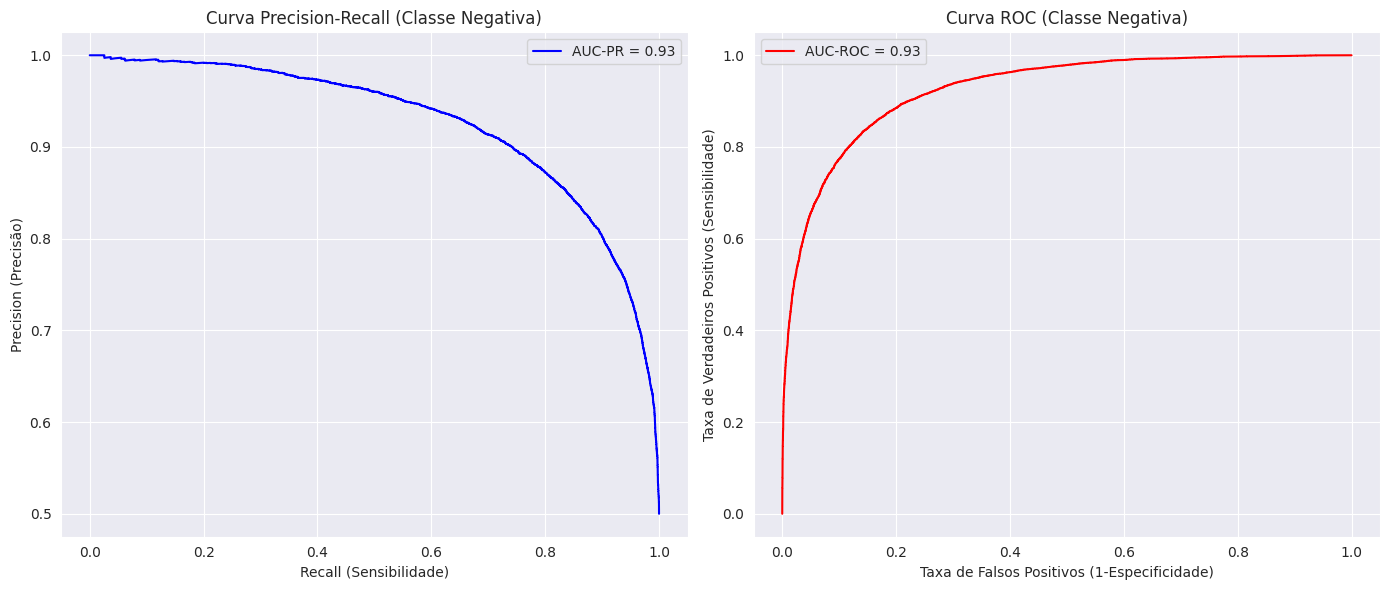

In [97]:
y_pred_neg = 1 - y_pred  # Probabilidades preditas para a classe negativa

# Curva Precision-Recall para a classe negativa
precision, recall, _ = precision_recall_curve(y_validation, y_pred_neg, pos_label=0)
auc_pr = auc(recall, precision)

# Curva ROC para a classe negativa
fpr, tpr, _ = roc_curve(y_validation, y_pred_neg, pos_label=0)
auc_roc = auc(fpr, tpr)

# Plotando as curvas
plt.figure(figsize=(14, 6))

# Curva Precision-Recall
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall (Classe Negativa)')
plt.legend()
plt.grid(True)

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', label=f'AUC-ROC = {auc_roc:.2f}')
plt.xlabel('Taxa de Falsos Positivos (1-Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC (Classe Negativa)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

For this problem I will consider all uncertain answers (between 0.4 and 0.6) as negative class. This will increase the recall but decrease my precision

## Metrics After Threshold

In [108]:
y_pred_thresh = (y_pred > 0.6).astype(int)

In [99]:
evaluate_metrics(y_validation, y_pred_thresh)

Accuracy: 0.8405
Precision: 0.8063
Recall: 0.8962
F1 Score: 0.8489


Nice! Our recall for Negative class got to almost 90%! 

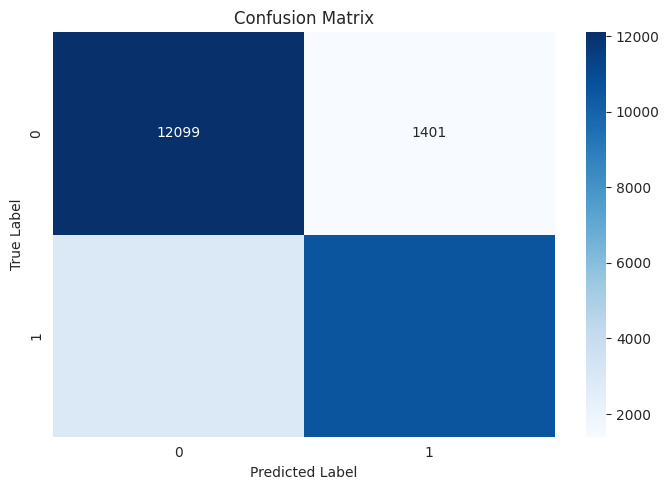

In [100]:
cmatrix2 = confusion_matrix(y_validation, y_pred_thresh)

# Plot Confusion Matrix
plt.figure(figsize=(7,5))
sns.heatmap(cmatrix2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

In [101]:
print(cmatrix2)

[[12099  1401]
 [ 2906 10594]]


<a name='7.4'></a>
## 7.4 Predict on Test

We have over 300.000 samples on test. I choose to work with 30.000(10%) because it's enough to see if the model can generalize.

In [102]:
df_test = pd.read_csv(PATH + 'test.csv')

### Clean Test

In [103]:
df_test.columns = ['sentiment','title','text']
df_test, _ = train_test_split(df_test, test_size=0.9, stratify=df_test['sentiment'], random_state=42)
df_test.head()

,sentiment,title,text
141420,2,"Excellent, and does what it's supposed to do",Although I would have appreciated a little mor...
244397,1,Meh,"Honestly, in the last...i felt there were 2 so..."
88758,1,Get over it dude,This is not a very good cd. Artimus needs to m...
191403,2,Polar Express Book and DVD,I would reccomend this book and video to every...
264369,1,Poor product description by amazon.com,"When I purchased this gage, the product descri..."


In [104]:
df_test = df_test.drop(['title'], axis=1)
df_test['text'] = df_test['text'].apply(process_text)

sequences_test = tokenizer.texts_to_sequences(df_test['text'])

X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [105]:
df_test['sentiment'] = df_test['sentiment'].apply(lambda x: 'Negative' if x == 1 else 'Positive')
df_test['sentiment'] = df_test['sentiment'].map(sentiment_map)
y_test = df_test['sentiment'].copy()

In [106]:
y_pred_test = model.predict(X_test)
y_pred_classes_test = (y_pred_test > 0.6).astype(int)


2023-09-28 14:54:30.988007: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 81917952 exceeds 10% of free system memory.


1250/1250 [==============================] - 123s 98ms/step


### Evaluate Test

In [107]:
evaluate_metrics(y_test, y_pred_classes_test)

Accuracy: 0.8404
Precision: 0.8060
Recall: 0.8967
F1 Score: 0.8489


Text(0.5, 1.0, 'Confusion Matrix')

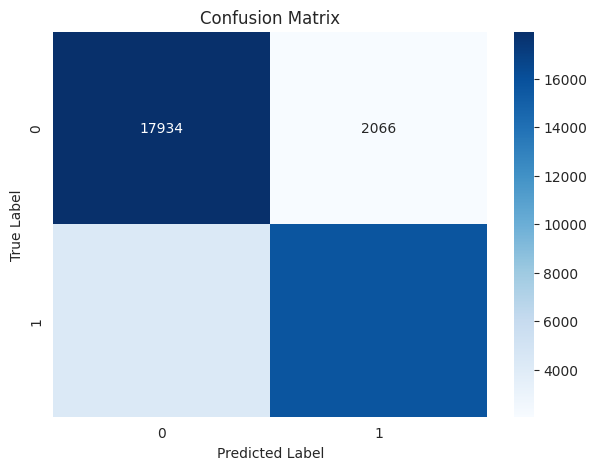

In [109]:
cm = confusion_matrix(y_test, y_pred_classes_test)

# Plot Confusion Matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [110]:
print(cm)

[[17934  2066]
 [ 4316 15683]]


<a name='8.0'></a>
# 8.0 Manual Texts Prediction

## Introducing the Neutral Sentiment Category

Upon analyzing the predictions of our model, I observed that for certain reviews, the model exhibited uncertainty or lacked strong confidence in its predictions. To accommodate such instances and offer a more nuanced classification, I've introduced a "Neutral" sentiment category.

The revised sentiment labeling based on the model's probability output is as follows:

- **Positive Sentiment**: When there's over 60% probability for a positive outcome.
- **Negative Sentiment**: When the positive probability is less than 40%.
- **Neutral Sentiment**: For cases where the model's positive probability lies between 40% and 60%, indicating a level of uncertainty.

This approach ensures a more comprehensive and nuanced analysis of reviews, capturing sentiments that may not strictly fall into the traditional positive or negative categories.


In [111]:
text_sample = """It takes about an hour to cook white rice. My older version rice cooker use to only take 40 mins. It also doesn't have the line inside for the water level for one cup of rice."""
predicted_sentiment = predict_manual_text(text_sample)
print(predicted_sentiment)

1/1 [==============================] - 0s 72ms/step
Negative


Review Analysis:

The review classified above received a 3-star rating. Notably, our model categorized it as 'Negative', a classification I concur with. However, if Amazon were solely focusing on 1 or 2-star ratings to pinpoint negative feedback, they would miss such insights.

In [112]:
text_sample = """The product is decent. I haven't had any significant issues with it, but it also doesn't stand out in any specific aspect."""
predicted_sentiment = predict_manual_text(text_sample)
print(predicted_sentiment)

1/1 [==============================] - 0s 93ms/step
Neutral


You can see that this review is misleading. It has some good and bad points, that cause the model to be uncertain. So this kind of uncertain reviews I choose to classify as neutral

<a name='9.0'></a>
# 9.0 Business Performance

## Assumptions

- On average, Amazon garners **10,000 reviews daily**.
- Of these, **5% (or 500 reviews)** are negative.
- Among the negative feedback, **20% are disguised as star ratings**. This means Amazon could potentially overlook **100 subtly critical reviews** each day.

## Cost of Dissatisfaction

- Each unidentified and unaddressed negative review risks losing a customer permanently.
- The estimated **Lifetime Value (LTV) of an Amazon customer stands at \\$500**, representing the potential profit derived from a customer throughout their association with the company.
- For the sake of this analysis, let's assume Amazon loses all customers associated with the **100 camouflaged negative reviews**.

## Recall: Before vs. After the Model Implementation

- Without the model in place, Amazon faces a potential loss of **100 customers daily**, translating to a revenue loss of **100 x \\$500 = \\$50,000 daily**.
- With the model's deployment, the recall rate surges to **89%**. This means Amazon now captures feedback from **89 of the camouflaged negative reviews daily**, missing only 11 such reviews.
- By this metric, instead of losing \\$50,000 daily, the model helps Amazon salvage 89 x \\$500 = \\$44,500 each day. Annually, this amounts to a substantial recovery of **\\$16,242,500**!